This module is for downloading [VIIRS Stray Light Corrected Nighttime Day/Night Band Composites Version 1](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) dataset from Google Earth Engine. The entire workflow works with a Pythonic approach.


In [31]:
# Connect to google drive and specify the file location at your 'Colab Notebooks' folder

from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/viirs_versatile'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Set-up**

In [32]:
RW_engine = 'pyogrio'
rasterSwitch = 'NO'

Mounting your GoogleDrive

Importing module(s)

In [33]:
!pip install geopandas richdem geemap rasterio import_ipynb pyshp pycrs pyogrio

In [34]:
# Colab default packages
import io
import os
import types
import sys
import glob
import importlib
import numpy as np
import pandas as pd
import json
import ee
from shapely.geometry import mapping
from shapely import geometry

# Temporarily installed packages
import geopandas as gpd
import rasterio
import richdem as rd
import geemap
import pyogrio
import pycrs
import import_ipynb

# Import external files
os.chdir(program_location)
!pwd

sys.path.append(program_location)

import tools
importlib.reload(tools)

/content/drive/MyDrive/Colab Notebooks/viirs_versatile


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/viirs_versatile/tools.py'>

In [35]:
!pip install earthengine-api --upgrade
#NOTE: https://developers.google.com/earth-engine/guides/python_install

Generating an 'output' foldirectory in the target city directory

In [36]:
data_loc = os.path.join(os.getcwd(), 'data')
output_loc = os.path.join(data_loc, 'output')

print(data_loc)
print(output_loc)

if not os.path.exists(output_loc):
    os.mkdir(output_loc)

/content/drive/MyDrive/Colab Notebooks/viirs_versatile/data
/content/drive/MyDrive/Colab Notebooks/viirs_versatile/data/output




---


# **Autharizing your GEE project**

In [37]:
# Initialize GEE
try:
        ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except Exception as e:
        ee.Authenticate()
        ee.Initialize(project='eigotateishi')# 'project = ###'. ### should be your own GEE project

---
#**Setting AOI**

In [38]:
# Get an AOI to extract VIIRS composites

src_adm = os.path.join(data_loc, 'adm0', 'wb_adm0.shp')
gdf_in = tools.vec_import(RW_engine, src_adm)

gdf_in.head(6)

Vector import complete.
GDF size:255
EPSG:4326


,OBJECTID,ISO_A2,WB_ADM0_CO,WB_ADM0_NA,Shape_Leng,ISO3,UN_m49,Region,incomeG,lendingC,FID_100,Shape_Le_1,Shape_Area,geometry
0,1,AF,1,Afghanistan,7.132529e+06,AFG,4,South Asia,Low income,IDA,0,58.987945,62.554886,"POLYGON ((70.99956 38.47933, 71.00709 38.47256..."
1,2,AL,3,Albania,1.743971e+06,ALB,8,Europe & Central Asia,Upper middle income,IBRD,100,13.472539,3.076363,"MULTIPOLYGON (((19.27697 40.51499, 19.28371 40..."
2,3,DZ,4,Algeria,8.933841e+06,DZA,12,Middle East & North Africa,Upper middle income,IBRD,200,75.649149,212.749398,"MULTIPOLYGON (((-1.12515 35.73673, -1.13231 35..."
3,4,AS,5,American Samoa (U.S.),1.744573e+05,ASM,16,East Asia & Pacific,Upper middle income,None,300,1.546519,0.017670,"MULTIPOLYGON (((-170.55238 -14.29367, -170.554..."
4,5,SD,6,Sudan,8.852111e+06,SDN,736,Sub-Saharan Africa,Lower middle income,IDA,400,77.888330,156.049197,"MULTIPOLYGON (((38.46807 18.09573, 38.46729 18..."
5,6,AD,7,Andorra,1.323715e+05,AND,20,None,None,None,500,1.060570,0.052022,"POLYGON ((1.56712 42.65319, 1.57111 42.64949, ..."


In [39]:
# Specify the file name prefix (example: ISO_viirs_)
viirs_prefix = 'CHE_viirs'

<Axes: >

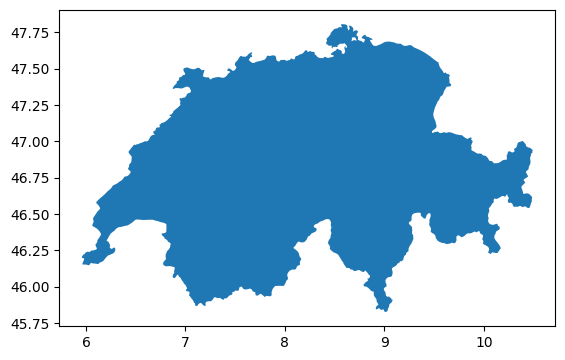

In [40]:
# Select adm if needed
gdf_in = gdf_in[gdf_in['ISO3'] == 'CHE']
gdf_in = gdf_in.to_crs('EPSG:4326')
gdf_in.plot()

In [41]:
aoi = geemap.geopandas_to_ee(gdf_in)
aoi_geomet = aoi.geometry()

# **Download**

All downloaded VIIRS raster images will be stored in /content/drive/MyDrive/* viirs_prefix *

### VIIRS Stray Light Corrected Nighttime Day/Night Band Composites Version 1

You can select VIIRS or VIIRS-LIKE.
For the VIIRS-LIKE dataset, see  https://essd.copernicus.org/articles/13/889/2021/  as well as https://gee-community-catalog.org/projects/npp_viirs_ntl/  for more details.

In [42]:
# Get all data
viirs_all = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad')

# Clip to the aoi
viirs_aoi = viirs_all.map(lambda x: x.clip(aoi_geomet))

In [43]:
# Define year for the analysis

for y in range(2014, 2024):
#for y in [2023]:#Use this if you want to download a particular single year.

    if y < 2023:
        for m in range(1, 13):# For now, all 1-12 2023 data are available. Modify this IF section if you want to download available months in 2024.
          print('Processing: {}-{}'.format(y, str(m).zfill(2)))

          viirs_tar = viirs_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('avg_rad')
          viirs_out = viirs_tar.sum()


          # Export
          viirs_name = viirs_prefix + '_' +  str(y) + str(m).zfill(2)

          geemap.ee_export_image_to_drive(
              viirs_out,
              folder = viirs_prefix,
              description = viirs_name,
              region = aoi_geomet,
              scale = 463.83)


    else:
        for m in range(1, 13):
          print('Processing: {}-{}'.format(y, str(m).zfill(2)))

          viirs_tar = viirs_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('avg_rad')
          viirs_out = viirs_tar.sum()


          # Export
          viirs_name = viirs_prefix + '_' + str(y) + str(m).zfill(2)

          geemap.ee_export_image_to_drive(
              viirs_out,
              folder = viirs_prefix,
              description = viirs_name,
              region = aoi_geomet,
              scale = 463.83)

Processing: 2014-01
Processing: 2014-02
Processing: 2014-03
Processing: 2014-04
Processing: 2014-05
Processing: 2014-06
Processing: 2014-07
Processing: 2014-08
Processing: 2014-09
Processing: 2014-10
Processing: 2014-11
Processing: 2014-12
Processing: 2015-01
Processing: 2015-02
Processing: 2015-03
Processing: 2015-04
Processing: 2015-05
Processing: 2015-06
Processing: 2015-07
Processing: 2015-08
Processing: 2015-09
Processing: 2015-10
Processing: 2015-11
Processing: 2015-12
Processing: 2016-01
Processing: 2016-02
Processing: 2016-03
Processing: 2016-04
Processing: 2016-05
Processing: 2016-06
Processing: 2016-07
Processing: 2016-08
Processing: 2016-09
Processing: 2016-10
Processing: 2016-11
Processing: 2016-12
Processing: 2017-01
Processing: 2017-02
Processing: 2017-03
Processing: 2017-04
Processing: 2017-05
Processing: 2017-06
Processing: 2017-07
Processing: 2017-08
Processing: 2017-09
Processing: 2017-10
Processing: 2017-11
Processing: 2017-12
Processing: 2018-01
Processing: 2018-02


Processing: 2020-10
Processing: 2020-11
Processing: 2020-12
Processing: 2021-01
Processing: 2021-02
Processing: 2021-03
Processing: 2021-04
Processing: 2021-05
Processing: 2021-06
Processing: 2021-07
Processing: 2021-08
Processing: 2021-09
Processing: 2021-10
Processing: 2021-11
Processing: 2021-12
Processing: 2022-01
Processing: 2022-02
Processing: 2022-03
Processing: 2022-04
Processing: 2022-05
Processing: 2022-06
Processing: 2022-07
Processing: 2022-08
Processing: 2022-09
Processing: 2022-10
Processing: 2022-11
Processing: 2022-12
Processing: 2023-01
Processing: 2023-02
Processing: 2023-03
Processing: 2023-04
Processing: 2023-05
Processing: 2023-06
Processing: 2023-07
Processing: 2023-08
Processing: 2023-09
Processing: 2023-10
Processing: 2023-11
Processing: 2023-12


### VIIRS Nighttime Day/Night Annual Band Composites V2.1 (used for background noise reduction)

In [44]:
# Get all data
viirs_ABCv21 = ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V21").select('average_masked')

# Clip to the aoi
viirs_ABCv21_aoi = viirs_ABCv21.map(lambda x: x.clip(aoi_geomet))

In [45]:
# Define year for the analysis

for y in range(2014, 2022):
    m = 1
    print('Processing: {}'.format(y))

    viirs_tar = viirs_ABCv21_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('average_masked')
    viirs_out = viirs_ABCv21_aoi.sum()


    # Export
    viirs_name = viirs_prefix + '_' + 'maskV21_' + str(y)

    geemap.ee_export_image_to_drive(
        viirs_out,
        folder = viirs_prefix,
        description = viirs_name,
        region = aoi_geomet,
        scale = 463.83)

Processing: 2014
Processing: 2015
Processing: 2016
Processing: 2017
Processing: 2018
Processing: 2019
Processing: 2020
Processing: 2021


### VIIRS Nighttime Day/Night Annual Band Composites V2.2 (used for background noise reduction)

In [46]:
# Get all data
viirs_ABCv22 = ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V22").select('average_masked')

# Clip to the aoi
viirs_ABCv22_aoi = viirs_ABCv22.map(lambda x: x.clip(aoi_geomet))

In [47]:
# Define year for the analysis

for y in [2022]:
    m = 1
    print('Processing: {}'.format(y))

    viirs_tar = viirs_ABCv22_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('average_masked')
    viirs_out = viirs_ABCv22_aoi.sum()

    # Export
    viirs_name = viirs_prefix + '_' + 'maskV22_' + str(y)

    geemap.ee_export_image_to_drive(
        viirs_out,
        folder = viirs_prefix,
        description = viirs_name,
        region = aoi_geomet,
        scale = 463.83)

Processing: 2022
